This model is based off of a neural network that performed well (> 99% accuracy) in model 2 for one of the authors (Purkeypile).

In [1]:
# all imports here to make it easy to pick up when
# the run time restarts
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import os
import opendatasets as od
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# seed the random number generator for consistent results
# from run to run
random.seed(1234)

In [2]:
# loading of the data in this cell based on Maha's cv_project 
od.download("https://www.kaggle.com/datasets/alistairking/recyclable-and-household-waste-classification")

# Define the path to the main images folder
IMAGE_DIR = './recyclable-and-household-waste-classification/images/images'
TRAIN_DIR = './split_dataset/train/images'
TEST_DIR = './split_dataset/test/images'
#VALIDATION_DIR = './split_dataset/val/images'   # not using, but would be easy to do

# Traverse the subdirectories and list images
image_paths = []
for root, dirs, files in os.walk(IMAGE_DIR):
    for file in files:
        # Append full path for each image file
        image_paths.append(os.path.join(root, file))


Skipping, found downloaded files in ".\recyclable-and-household-waste-classification" (use force=True to force download)


In [3]:
# Print total number of images
print(len(image_paths))

15000


./recyclable-and-household-waste-classification/images/images\shoes\default\Image_99.png


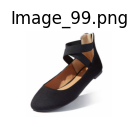

./recyclable-and-household-waste-classification/images/images\newspaper\default\Image_72.png


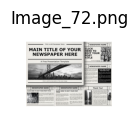

./recyclable-and-household-waste-classification/images/images\cardboard_boxes\real_world\Image_247.png


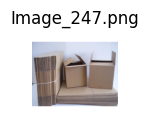

./recyclable-and-household-waste-classification/images/images\aerosol_cans\default\Image_209.png


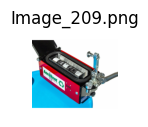

./recyclable-and-household-waste-classification/images/images\aluminum_soda_cans\real_world\Image_86.png


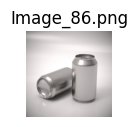

In [4]:
# Display a few random sample images
NUM_SAMPLES_TO_DISPLAY = 5

for i in range(NUM_SAMPLES_TO_DISPLAY):
    image_path = image_paths[random.randrange(len(image_paths))]
    print(image_path)
    image = Image.open(image_path)

    # Display the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

In [8]:
DEFAULT_DIR = "default"
REAL_WORLD_DIR = "real_world"

# Ensure directories exist
os.makedirs(TRAIN_DIR, exist_ok = True)
os.makedirs(TEST_DIR, exist_ok = True)

def default_or_realworld(image_path):
    # this is kind of hacky to look for it as a string
    # a better way would be to step "up" one directory and see what it is
    if DEFAULT_DIR in image_path.lower():
        return DEFAULT_DIR
    elif REAL_WORLD_DIR in image_path.lower():
        return REAL_WORLD_DIR
    else:
        raise ValueError(image_path + " does not contain " + DEFAULT_DIR + " or " + REAL_WORLD_DIR)

# Process each class in the source directory
for class_name in os.listdir(IMAGE_DIR):
    class_path = os.path.join(IMAGE_DIR, class_name)
    if os.path.isdir(class_path):  # Ensure it’s a directory (class folder)
        print("Processing " + class_name + "...")
        
        # Create class folders in train and test directories
        os.makedirs(os.path.join(TRAIN_DIR, class_name), exist_ok = True)
        os.makedirs(os.path.join(TEST_DIR, class_name), exist_ok = True)

        # Collect all image file paths from any subdirectories within this class folder
        images = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
                    images.append(os.path.join(root, file))

        # Shuffle and split images into 80/20 train/test
        random.shuffle(images)
        split_idx = int(len(images) * 0.8)
        train_images = images[: split_idx]
        test_images = images[split_idx :]

        # Copy images to train and test directories
        # there are duplicate file names in the default and real
        # world directories, so add that onto the names to make them
        # unique. also only copy if not already present so subsequent
        # runs are faster if this is already done
        for image_path in train_images:
            dest_path = os.path.join(TRAIN_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

        for image_path in test_images:
            dest_path = os.path.join(TEST_DIR, class_name, default_or_realworld(image_path) + os.path.basename(image_path))
            if os.path.exists(dest_path) == False:
                shutil.copyfile(image_path, dest_path)

print("Dataset successfully split into train and test folders!")

Processing aerosol_cans...
Processing aluminum_food_cans...
Processing aluminum_soda_cans...
Processing cardboard_boxes...
Processing cardboard_packaging...
Processing clothing...
Processing coffee_grounds...
Processing disposable_plastic_cutlery...
Processing eggshells...
Processing food_waste...
Processing glass_beverage_bottles...
Processing glass_cosmetic_containers...
Processing glass_food_jars...
Processing magazines...
Processing newspaper...
Processing office_paper...
Processing paper_cups...
Processing plastic_cup_lids...
Processing plastic_detergent_bottles...
Processing plastic_food_containers...
Processing plastic_shopping_bags...
Processing plastic_soda_bottles...
Processing plastic_straws...
Processing plastic_trash_bags...
Processing plastic_water_bottles...
Processing shoes...
Processing steel_food_cans...
Processing styrofoam_cups...
Processing styrofoam_food_containers...
Processing tea_bags...
Dataset successfully split into train and test folders!


In [9]:
# return the valid ones too, cause if the directory
# doesn't exist then there are 0 invalid and it 
# seems like everything is ok when it isn't.
def check_images(directory):
    invalid_images = []
    valid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.png'):
                try:
                    img = Image.open(os.path.join(root, file))
                    # note: this returns none and throws an exception if invalid
                    # (I was expecting it to return a bool- exceptions shouldn't
                    # be used for flow control)
                    img.verify()  # Verify image integrity
                    valid_images.append(os.path.join(root, file))
                except Exception as e:
                    invalid_images.append(os.path.join(root, file))
    return valid_images, invalid_images

valid_train, invalid_train = check_images(TRAIN_DIR)
valid_test, invalid_test = check_images(TEST_DIR)

print("Valid train images: " + str(len(valid_train)) + ", invalid train images: " + str(len(invalid_train)))
print("Valid test images: " + str(len(valid_test)) + ", invalid test images: " + str(len(invalid_test)))

total_found = (len(valid_train) + len(invalid_train) + len(valid_test) + len(invalid_test))
print("Total images found in training and testing sets: " + str(total_found))
print("Expected images from source: " + str(len(image_paths)))
if  total_found != len(image_paths):
    print("MISSING FILES IN TESTING OR TRAINING SET!!!")
else:
    print("Found all expected files in training and testing")

Valid train images: 12000, invalid train images: 0
Valid test images: 3000, invalid test images: 0
Total images found in training and testing sets: 15000
Expected images from source: 15000
Found all expected files in training and testing


In [10]:
IMG_SIZE = 224
BATCH_SIZE = 64

# Define data transformations
# numbers based on Maha's code
custom_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

## Load datasets
train_dataset = ImageFolder(root = TRAIN_DIR, transform = custom_transform)
test_dataset = ImageFolder(root = TEST_DIR, transform = custom_transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [11]:
# there is a very small, but non-zero chance that one of
# the data sets is missing an entire class- so account for that
train_class_names = train_dataset.classes
test_class_names = test_dataset.classes

class_names = set(train_class_names + test_class_names)

print("Class labels:", class_names)

num_classes = len(class_names)
print("\nNumber of classes: " + str(num_classes))

Class labels: {'eggshells', 'aerosol_cans', 'clothing', 'plastic_cup_lids', 'cardboard_boxes', 'tea_bags', 'glass_cosmetic_containers', 'aluminum_soda_cans', 'disposable_plastic_cutlery', 'magazines', 'aluminum_food_cans', 'shoes', 'cardboard_packaging', 'plastic_food_containers', 'glass_food_jars', 'styrofoam_cups', 'plastic_soda_bottles', 'plastic_straws', 'plastic_water_bottles', 'newspaper', 'styrofoam_food_containers', 'food_waste', 'plastic_trash_bags', 'glass_beverage_bottles', 'office_paper', 'steel_food_cans', 'paper_cups', 'plastic_shopping_bags', 'plastic_detergent_bottles', 'coffee_grounds'}

Number of classes: 30


In [28]:
# if you play around with this you can see they're 
# sorted by target
start_index = -50
for i in range(start_index, start_index + 10):
    print(train_dataset[i][1])   # print the target/label

29
29
29
29
29
29
29
29
29
29


In [ ]:
### from mod 2 ###
# need to one hot encode them?
#train_targets = keras.utils.to_categorical(y_train, NUM_CLASSES)
#test_targets = keras.utils.to_categorical(y_test, NUM_CLASSES)

#if K.image_data_format() == 'channels_first':
#    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
#    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
#    input_shape = (1, img_rows, img_cols)
#    CurDataFormat = 'channels_first'
#else:
#    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
#    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
#    input_shape = (img_rows, img_cols, 1)
#    CurDataFormat = 'channels_last'

In [31]:
#### RAW COPY FROM MODULE 2- NEED TO UPDATE ####
# based on the following:
# https://medium.com/@BrendanArtley/mnist-keras-simple-cnn-99-6-731b624aee7f
from tensorflow.keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras import backend as K

DROP_OUT_RATE = 0.05

model = Sequential()

if K.image_data_format() == 'channels_first':
    cur_data_format = 'channels_first'
else:
    cur_data_format = 'channels_last'

#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=CurDataFormat,
#                 input_shape=(IMG_SIZE, IMG_SIZE, 3)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(DROP_OUT_RATE))

#model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
#model.add(Dropout(DROP_OUT_RATE))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(DROP_OUT_RATE))

#model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format=cur_data_format))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
#model.add(Dropout(DROP_OUT_RATE))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(DROP_OUT_RATE))

model.add(Dense(num_classes, activation='softmax'))

In [32]:
NUM_EPOCHS = 10

print(model.summary())
print()

model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

#hist = model.fit(TrainInput, TrainTarget, epochs = 20, batch_size = 128,
#                  validation_data=(TestInput, TestTarget), verbose = 1)

#ValueError: Exception encountered when calling Sequential.call().
#
#Input 0 of layer "conv2d_12" is incompatible with the layer: expected axis 1 of input shape to have value 224, but received input with shape (None, 3, 224, 224)
#
#Arguments received by Sequential.call():
#  • inputs=tf.Tensor(shape=(None, 3, 224, 224), dtype=float32)
#  • training=True
#  • mask=None
#hist = model.fit(train_loader, epochs = 20, batch_size = 256,
#                  validation_data = val_loader, verbose = 1)

hist = model.fit(train_loader, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                 validation_data = test_loader, verbose = 1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/10


ValueError: Exception encountered when calling MaxPooling2D.call().

[1mNegative dimension size caused by subtracting 2 from 1 for '{{node sequential_3_1/max_pooling2d_7_1/MaxPool2d}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](sequential_3_1/batch_normalization_13_1/batchnorm/add_1)' with input shapes: [?,1,112,64].[0m

Arguments received by MaxPooling2D.call():
  • inputs=tf.Tensor(shape=(None, 1, 112, 64), dtype=float32)

In [ ]:
# Measure test accuracy
scores = hist.history['accuracy']
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Draw Learning curve
def learning_curve(hist):
  #Create a function to draw learning curves
  # This will help you to just call this function in future for drawing the learning curves
  metrics = ['loss', 'accuracy']
  # based on the lab
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(hist.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(hist.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])